In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
import netCDF4
import numpy
import os
import pandas
from PIL import Image
import random
import readline
import scipy
from scipy import fft
from scipy import linalg
from scipy import stats
from scipy.stats import poisson, ttest_ind
import seaborn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/Output_Files/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_Output_V3.csv')
    ET_DF = Open_File(Diri+Model+'_ET_Output_V3.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V3.csv')
    Time = []
    Start_Time = []
    End_Time = []
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Start_Time.append(Datetime(ET_DF["Start Time"][j]))
        End_Time.append(Datetime(ET_DF["End Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["Start Time"] = Start_Time
    ET_DF["End Time"] = End_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [7]:
Control_Data[265:277]

,level_0,Code,Name,Lon,Lat,SLP(hPa),Winds(m/s),B,VLT,VUT,Time(Z),Storm Phase
265,62,TC190105,Lydia,-56.33,37.40,948.48,41.5,9.05,236.10,289.92,1901-09-27 00:00:00,Tropical
266,63,TC190105,Lydia,-54.83,38.25,950.98,39.9,11.90,234.39,267.61,1901-09-27 06:00:00,Tropical
267,64,TC190105,Lydia,-53.37,39.19,953.76,43.1,18.13,224.89,230.05,1901-09-27 12:00:00,Transition
268,65,TC190105,Lydia,-51.56,40.08,952.91,42.0,31.98,231.25,195.68,1901-09-27 18:00:00,Transition
269,66,TC190105,Lydia,-49.70,42.10,951.29,38.4,43.81,253.98,172.97,1901-09-28 00:00:00,Transition
270,67,TC190105,Lydia,-49.51,44.55,948.89,44.0,41.29,241.12,161.34,1901-09-28 06:00:00,Transition
271,68,TC190105,Lydia,-49.52,44.98,949.44,43.2,38.45,220.08,156.22,1901-09-28 12:00:00,Transition
272,69,TC190105,Lydia,-48.37,45.66,952.82,37.7,28.80,201.31,169.85,1901-09-28 18:00:00,Transition
273,70,TC190105,Lydia,-47.67,46.28,959.65,33.9,14.50,153.80,168.18,1901-09-29 00:00:00,Transition
274,71,TC190105,Lydia,-46.92,46.83,963.87,31.0,4.41,76.01,151.33,1901-09-29 06:00:00,Transition


In [8]:
Control_ET[5:8]

,Code,Name,Path Type,Start Time,End Time,Min SLP,Start SLP,End SLP,Start Lon,Start Lat,End Lon,End Lat,ET Dist (km),ET Duration (hr),Trop Duration (hr)
5,TC190105,Lydia,1,1901-09-27 12:00:00,1901-09-29 18:00:00,913.33,953.76,970.00,-53.37,39.19,-42.82,48.53,1335.846025,54.0,384.0
6,TC190106,Mario,1,1901-09-22 00:00:00,1901-09-22 18:00:00,988.80,993.69,991.98,-78.47,35.78,-71.20,41.68,909.539822,18.0,72.0
7,TC190107,Nicole,2,1901-10-14 12:00:00,1901-10-15 00:00:00,974.56,1015.94,1019.52,-22.00,42.00,-26.00,41.25,343.074813,12.0,246.0


In [9]:
Control_Codes[5:8]

,ABC,Orig Code,New Code,Name
5,A,89,TC190105,Lydia
6,A,90,TC190106,Mario
7,A,95,TC190107,Nicole


In [10]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [11]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    return (DF_Storm)

In [12]:
# Function to Plot Cumulative Distribution Functions
def Cum_Dist(Array, Direction):
    Array = Array[Array > -728]
    if Direction == "Up":
        Sorted = numpy.sort(Array)
    else:
        Sorted = numpy.sort(Array)[::-1]
    Len = len(Sorted)
    Density = numpy.arange(0,1.0001,1/(Len-1))
    return (Sorted, Density)

In [13]:
# Function to Plot Cumulative Distribution Functions
def Cum_Dist_Date(Array):
    Days_Array = numpy.zeros(len(Array))
    for i in range(len(Array)):
        Time = Array[i].date()
        Year = Time.year
        NYD = datetime.date(Year,1,1)
        Days = Time - NYD
        Days_Array[i] = Days.days
    Sorted = numpy.sort(Days_Array)
    Len = len(Sorted)
    Density = numpy.arange(0,1.0001,1/(Len-1))
    return (Sorted, Density)

In [14]:
Month_Days = numpy.zeros(13)
for m in range(13):
    if m < 12:
        Days = datetime.date(2023,m+1,1) - datetime.date(2023,1,1)
        Month_Days[m] = int(Days.days)
    else:
        Month_Days[m] = 365
Month_Days
Months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan"]

In [15]:
# Function to Plot Probability Distribution Functions
def Prob_Dist(DF, Var, Unit, Width):
    DF = DF[DF[Var] > -728]
    Len = len(DF)
    Min = (int(numpy.min(DF[Var]) / Unit)) * Unit
    Max = (int(numpy.max(DF[Var]) / Unit) + 1) * Unit
    Values = Create_Bins(Min, Max, Unit)
    Ratio = int(Width / Unit)
    Counting = numpy.zeros(len(Values))
    Final = len(Values)-1
    for l in range(len(Counting)):
        if l == 0 or l == Final:
            Counting[l] = 0
        else:
            DF_Range = DF[(DF[Var] > (Values[l]-Width)) & (DF[Var] < (Values[l]+Width))]
            Counting[l] = len(DF_Range) / (2 * Width)
#            print (l, len(DF_Range), Counting[l])
    Density = Counting / Len
    return (Values, Density)

In [16]:
# Function to Plot Probability Distribution Functions
def Prob_Dist_0(DF, Var):
    DF = DF[DF[Var] > -728]
    Len = len(DF)
# ET Duration
    if Var == "ET Duration (hr)":
        Max = (int(numpy.max(DF[Var]) / 24) + 1) * 24
        Values_1 = numpy.array([0,6,12,18,24,30,36,42])
        Values_2 = Create_Bins(48, Max, 12)
        Values = numpy.concatenate([Values_1, Values_2])
        Counting = numpy.zeros(len(Values))
        Final = len(Values)-1
        for l in range(len(Counting)):
            if l <= 4:
                DF_Range = DF[DF[Var] == (Values[l])]
                Counting[l] = len(DF_Range) / 6
            elif l <= 8:
                DF_Range = DF[(DF[Var] > (Values[l]-6)) & (DF[Var] <= (Values[l]+6))]
                Counting[l] = len(DF_Range) / 12
            elif l < Final:
                DF_Range = DF[(DF[Var] > (Values[l]-12)) & (DF[Var] <= (Values[l]+12))]
                Counting[l] = len(DF_Range) / 24
            else:
                Counting[l] = 0
# Tropical Duration
    if Var == "Trop Duration (hr)":
        Max = (int(numpy.max(DF[Var]) / 48) + 1) * 48
        Values_1 = numpy.array([0,12,24,36,48,60])
        Values_2 = Create_Bins(72, Max, 24)
        Values = numpy.concatenate([Values_1, Values_2])
        Counting = numpy.zeros(len(Values))
        Final = len(Values)-1
        for l in range(len(Counting)):
            if l <= 6:
                DF_Range = DF[(DF[Var] > (Values[l]-12)) & (DF[Var] <= (Values[l]+12))]
                Counting[l] = len(DF_Range) / 24
            elif l < Final:
                DF_Range = DF[(DF[Var] > (Values[l]-24)) & (DF[Var] <= (Values[l]+24))]
                Counting[l] = len(DF_Range) / 48
            else:
                Counting[l] = 0
# ET Distance
    if Var == "ET Dist (km)":
        Max = (int(numpy.max(DF[Var]) / 250) + 1) * 250
        Values_1 = numpy.array([0,100,200,300,400])
        Values_2 = Create_Bins(500, Max, 250)
        Values = numpy.concatenate([Values_1, Values_2])
        Counting = numpy.zeros(len(Values))
        Final = len(Values)-1
        for l in range(len(Counting)):
            if l == 0:
                DF_Range = DF[DF[Var] == (Values[l])]
                Counting[l] = len(DF_Range) / 100
            elif l <= 5:
                DF_Range = DF[(DF[Var] > (Values[l]-100)) & (DF[Var] < (Values[l]+100))]
                Counting[l] = len(DF_Range) / 200
            elif l < Final:
                DF_Range = DF[(DF[Var] > (Values[l]-250)) & (DF[Var] < (Values[l]+250))]
                Counting[l] = len(DF_Range) / 500
            else:
                Counting[l] = 0
    Density = Counting / Len
    return (Values, Density)

In [17]:
# Function to Plot Probability Distribution Functions
def Prob_Dist_Date(DF, Var):
    Len = len(DF)
    Days = numpy.arange(Len)
    for i in range(len(Days)):
        Time = DF[Var][i].date()
        Year = Time.year
        NYD = datetime.date(Year,1,1)
        Days[i] = (Time - NYD).days
    DF["Days"] = Days
    Values = Create_Bins(0, 364, 5)
    Values[len(Values)-1] = 364.99
    Final = len(Values)-1
    Counting = numpy.zeros(len(Values))
    for l in range(len(Counting)):
        if l < 2:
            DF_Range = DF[(DF["Days"] < (Values[l]+15)) | (DF["Days"] > (350+Values[l]))]
        elif l > Final-2:
            DF_Range = DF[(DF["Days"] > (Values[l]-15)) | (DF["Days"] < (Values[l]-350))]
        else:
            DF_Range = DF[(DF["Days"] > (Values[l]-15)) & (DF["Days"] < (Values[l]+15))]
        Counting[l] = len(DF_Range) / 30
    Density = Counting / Len
    return (Values, Density)

In [18]:
# Formatting Based on Variable
def Cum_Dist_Formatting(Vals_1, Vals_2, Vals_3, Var):
# x Ticks and Lims
    if Var == "Start Lat" or Var == "End Lat":
        Min = 0
        Max = 60
        Width = 5
    elif Var == "Start Lon" or Var == "End Lon":
        Min = -100
        Max = 10
        Width = 10
    elif Var == "Start SLP" or Var == "End SLP" or Var == "Transitioning Min SLP" or \
    Var == "Post-transition Min SLP":
        Min = 900
        Max = 1020
        Width = 10
    elif Var == "Transition End-Start SLP Diff" or Var == "Transition Min-Start SLP Diff":
        Width = 10
        Min_Val = numpy.min([numpy.min(Vals_1), numpy.min(Vals_2), numpy.min(Vals_3)])
        Max_Val = numpy.max([numpy.max(Vals_1), numpy.max(Vals_2), numpy.max(Vals_3)])
        Min = (int(Min_Val / Width) - 1) * Width
        Max = (int(Max_Val / Width) + 1) * Width
    else:
        if Var == "ET Dist (km)":
            Width = 500
        else:
            Width = 50
        Min = 0
        Max_Val = numpy.max([numpy.max(Vals_1), numpy.max(Vals_2), numpy.max(Vals_3)])
        Max = (int(Max_Val / Width) + 1) * Width
    x_Ticks = Create_Bins(Min, Max, Width)
#
# y Ticks and Lims
    if Var == "Start Lat" or Var == "End Lat":
        pyplot.yticks(x_Ticks)
        pyplot.ylim(Min, Max)
        pyplot.xticks(Create_Bins(0,1,0.125))
        pyplot.xlim(0,1)
    elif Var == "Start Time":
        pyplot.xticks(Month_Days, Months)
        pyplot.xlim(-1,366)
        pyplot.yticks(Create_Bins(0,1,0.125))
        pyplot.ylim(0,1)
    else:
        pyplot.xticks(x_Ticks)
        pyplot.xlim(Min, Max)
        pyplot.yticks(Create_Bins(0,1,0.125))
        pyplot.ylim(0,1)
#
# Labels and Title
    if Var == "Start Lat" or Var == "End Lat":
        pyplot.xlabel("Cumulative Frequency Density", fontsize=18)
        pyplot.ylabel("Latitude", fontsize=18)
        Title = Var + "itude of ET Transition"
    else:
        pyplot.ylabel("Cumulative Frequency Density", fontsize=18)
        if Var == "Start Lon" or Var == "End Lon":
            pyplot.xlabel("Longitude", fontsize=18)
            Title = Var + "gitude of ET Transition"
        elif Var == "Start SLP" or Var == "End SLP":
            pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
            Title = Var + " of ET Transition"
        elif Var == "ET Duration (hr)":
            pyplot.xlabel("ET Transition Duration (hr)", fontsize=18)
            Title = "Duration of ET Transition"
        elif Var == "Trop Duration (hr)":
            pyplot.xlabel("Trop Duration (hr)", fontsize=18)
            Title = "Duration of Tropical Phase Before ET Transition"
        elif Var == "ET Dist (km)":
            pyplot.xlabel("ET Transition Distance (km)", fontsize=18)
            Title = "Distance Travelled During ET Transition"
        elif Var == "Start Time":
            pyplot.xlabel("Month", fontsize=18)
            Title = "Date of Beginning of ET Transition"
        elif Var == "Transitioning Min SLP":
            pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
            Title = "Minimum SLP During Transitioning Phase"
        elif Var == "Post-transition Min SLP":
            pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
            Title = "Minimum SLP After ET Transition Completion"
        elif Var == "Transition End-Start SLP Diff":
            pyplot.xlabel("Sea Level Pressure (SLP) Diff", fontsize=18)
            Title = "SLP Diff Between ET Transition End - Start"
        elif Var == "Transition Min-Start SLP Diff":
            pyplot.xlabel("Sea Level Pressure (SLP) Diff", fontsize=18)
            Title = "SLP Diff Between ET Transition Minimum - Start"
    pyplot.title(Title, fontsize=25)
#
# Legend
    if Var == "ET Duration (hr)" or Var == "Trop Duration (hr)" or Var == "ET Dist (km)" or Var == "Start Time":
        pyplot.legend(loc=4, fontsize=15)
    else:
        pyplot.legend(loc=3, fontsize=15)

In [19]:
# Create Function to Plot ET Cumulative Distributions
def ET_Cum_Dist_Plot(Fig, ET_DF_1, ET_DF_2, ET_DF_3, Var):
    if Var == "Start Lat" or Var == "Start Lon" or Var == "Start SLP" or Var == "ET Duration (hr)" or \
    Var == "ET Dist (km)" or Var == "Transitioning Min SLP" or Var == "Transition End-Start SLP Diff":
        Axis = Fig.add_subplot(1,2,1)
    elif Var == "End Lat" or Var == "End Lon" or Var == "End SLP" or Var == "Trop Duration (hr)" or \
    Var == "Start Time" or Var == "Post-transition Min SLP" or Var == "Transition Min-Start SLP Diff":
        Axis = Fig.add_subplot(1,2,2)
#
# Apply Cumulative Distribution Function
    if Var == "Start Lat" or Var == "End Lat" or Var == "ET Duration (hr)" or Var == "ET Dist (km)" or \
    Var == "Trop Duration (hr)":
        Sorted_1, Density_1 = Cum_Dist(ET_DF_1[Var], "Up")
        Sorted_2, Density_2 = Cum_Dist(ET_DF_2[Var], "Up")
        Sorted_3, Density_3 = Cum_Dist(ET_DF_3[Var], "Up")
    elif Var == "Start Lon" or Var == "End Lon" or Var == "Start SLP" or Var == "End SLP" or \
    Var == "Transitioning Min SLP" or Var == "Post-transition Min SLP" or \
    Var == "Transition End-Start SLP Diff" or Var == "Transition Min-Start SLP Diff":
        Sorted_1, Density_1 = Cum_Dist(ET_DF_1[Var], "Down")
        Sorted_2, Density_2 = Cum_Dist(ET_DF_2[Var], "Down")
        Sorted_3, Density_3 = Cum_Dist(ET_DF_3[Var], "Down")
    elif Var == "Start Time":
        Sorted_1, Density_1 = Cum_Dist_Date(ET_DF_1[Var])
        Sorted_2, Density_2 = Cum_Dist_Date(ET_DF_2[Var])
        Sorted_3, Density_3 = Cum_Dist_Date(ET_DF_3[Var])
#
# Plotting
    if Var == "Start Lat" or Var == "End Lat":
        Axis.plot(Density_1, Sorted_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Density_2, Sorted_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Density_3, Sorted_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Sorted_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Sorted_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Sorted_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
#
# Formatting Based on Variable
    Cum_Dist_Formatting(Sorted_1, Sorted_2, Sorted_3, Var)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [20]:
# Formatting Based on Variable
def Prob_Dist_Formatting(Vals_1, Vals_2, Vals_3, Dens_1, Dens_2, Dens_3, Var):
# x Ticks and Lims
    if Var == "Start Lat" or Var == "End Lat":
        Min = 0
        Max = 60
        Width = 5
    elif Var == "Start Lon" or Var == "End Lon":
        Min = -100
        Max = 10
        Width = 10
    elif Var == "Start SLP" or Var == "End SLP" or Var == "Transitioning Min SLP" or \
    Var == "Post-transition Min SLP":
        Min = 900
        Max = 1020
        Width = 10
    elif Var == "Transition End-Start SLP Diff" or Var == "Transition Min-Start SLP Diff":
        Width = 10
        Min_Val = numpy.min([numpy.min(Vals_1), numpy.min(Vals_2), numpy.min(Vals_3)])
        Max_Val = numpy.max([numpy.max(Vals_1), numpy.max(Vals_2), numpy.max(Vals_3)])
        Min = (int(Min_Val / Width) - 1) * Width
        Max = (int(Max_Val / Width) + 1) * Width
    else:
        if Var == "ET Dist (km)":
            Width = 500
        else:
            Width = 50
        Min = 0
        Max_Val = numpy.max([numpy.max(Vals_1), numpy.max(Vals_2), numpy.max(Vals_3)])
        Max = (int(Max_Val / Width) + 1) * Width
    x_Ticks = Create_Bins(Min, Max, Width)
#
# y Ticks and Lims
    Max_Dens = numpy.max([numpy.max(Dens_1), numpy.max(Dens_2), numpy.max(Dens_3)])
    if Max_Dens <= 0.003:
        y_Width = 0.0002
    elif Max_Dens <= 0.006:
        y_Width = 0.0005
    elif Max_Dens <= 0.012:
        y_Width = 0.001
    elif Max_Dens <= 0.025:
        y_Width = 0.002
    elif Max_Dens <= 0.06:
        y_Width = 0.005
    elif Max_Dens <= 0.12:
        y_Width = 0.01
    elif Max_Dens <= 0.25:
        y_Width = 0.02
    else:
        y_Width = 0.05
    y_Max = (int(Max_Dens / y_Width) + 1) * y_Width
    y_Ticks = Create_Bins(0, y_Max, y_Width)
#
    if Var == "Start Lat" or Var == "End Lat":
        pyplot.yticks(x_Ticks)
        pyplot.ylim(Min, Max)
        pyplot.xticks(y_Ticks)
        pyplot.xlim(0, y_Max)
    else:
        pyplot.yticks(y_Ticks)
        pyplot.ylim(0, y_Max)
        if Var == "Start Time":
            pyplot.xticks(Month_Days, Months)
            pyplot.xlim(-1,366)
        else:
            pyplot.xticks(x_Ticks)
            pyplot.xlim(Min, Max)
#
# Labels and Title
    if Var == "Start Lat" or Var == "End Lat":
        pyplot.xlabel("Probability Frequency Density", fontsize=18)
        pyplot.ylabel("Latitude", fontsize=18)
        Title = Var + "itude of ET Transition"
    else:
        pyplot.ylabel("Cumulative Frequency Density", fontsize=18)
        if Var == "Start Lon" or Var == "End Lon":
            pyplot.xlabel("Longitude", fontsize=18)
            Title = Var + "gitude of ET Transition"
        elif Var == "Start SLP" or Var == "End SLP":
            pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
            Title = Var + " of ET Transition"
        elif Var == "ET Duration (hr)":
            pyplot.xlabel("ET Transition Duration (hr)", fontsize=18)
            Title = "Duration of ET Transition"
        elif Var == "Trop Duration (hr)":
            pyplot.xlabel("Trop Duration (hr)", fontsize=18)
            Title = "Duration of Tropical Phase Before ET Transition"
        elif Var == "ET Dist (km)":
            pyplot.xlabel("ET Transition Distance (km)", fontsize=18)
            Title = "Distance Travelled During ET Transition"
        elif Var == "Start Time":
            pyplot.xlabel("Month", fontsize=18)
            Title = "Date of Beginning of ET Transition"
        elif Var == "Transitioning Min SLP":
            pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
            Title = "Minimum SLP During Transitioning Phase"
        elif Var == "Post-transition Min SLP":
            pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
            Title = "Minimum SLP After ET Transition Completion"
        elif Var == "Transition End-Start SLP Diff":
            pyplot.xlabel("Sea Level Pressure (SLP) Diff", fontsize=18)
            Title = "SLP Diff Between ET Transition End - Start"
        elif Var == "Transition Min-Start SLP Diff":
            pyplot.xlabel("Sea Level Pressure (SLP) Diff", fontsize=18)
            Title = "SLP Diff Between ET Transition Min - Start"
    pyplot.title(Title, fontsize=25)
#
# Legend
    if Var == "Start SLP" or Var == "End SLP" or Var == "Start Time" or \
    Var == "Transitioning Min SLP" or Var == "Post-transition Min SLP" or \
    Var == "Transition End-Start SLP Diff" or Var == "Transition Min-Start SLP Diff":
        pyplot.legend(loc=2, fontsize=15)
    else:
        pyplot.legend(loc=1, fontsize=15)

In [21]:
# Create Function to Plot ET Probability Distributions
def ET_Prob_Dist_Plot(Fig, ET_DF_1, ET_DF_2, ET_DF_3, Var):
    if Var == "Start Lat" or Var == "Start Lon" or Var == "Start SLP" or Var == "ET Duration (hr)" or \
    Var == "ET Dist (km)" or Var == "Transitioning Min SLP" or Var == "Transition End-Start SLP Diff":
        Axis = Fig.add_subplot(1,2,1)
    elif Var == "End Lat" or Var == "End Lon" or Var == "End SLP" or Var == "Trop Duration (hr)" or \
    Var == "Start Time" or Var == "Post-transition Min SLP" or Var == "Transition Min-Start SLP Diff":
        Axis = Fig.add_subplot(1,2,2)
#
# Apply Probability Distribution Function
    if Var == "Start Lat" or Var == "End Lat":
        Values_1, Density_1 = Prob_Dist(ET_DF_1, Var, 2.5, 2.5)
        Values_2, Density_2 = Prob_Dist(ET_DF_2, Var, 2.5, 2.5)
        Values_3, Density_3 = Prob_Dist(ET_DF_3, Var, 2.5, 2.5)
    if Var == "Start Lon" or Var == "End Lon":
        Values_1, Density_1 = Prob_Dist(ET_DF_1, Var, 5, 5)
        Values_2, Density_2 = Prob_Dist(ET_DF_2, Var, 5, 5)
        Values_3, Density_3 = Prob_Dist(ET_DF_3, Var, 5, 5)
    if Var == "Start SLP" or Var == "End SLP" or Var == "Transitioning Min SLP" or \
    Var == "Post-transition Min SLP" or Var == "Transition End-Start SLP Diff" or \
    Var == "Transition Min-Start SLP Diff":
        Values_1, Density_1 = Prob_Dist(ET_DF_1, Var, 5, 5)
        Values_2, Density_2 = Prob_Dist(ET_DF_2, Var, 5, 5)
        Values_3, Density_3 = Prob_Dist(ET_DF_3, Var, 5, 5)
    if Var == "ET Duration (hr)" or Var == "Trop Duration (hr)" or Var == "ET Dist (km)":
        Values_1, Density_1 = Prob_Dist_0(ET_DF_1, Var)
        Values_2, Density_2 = Prob_Dist_0(ET_DF_2, Var)
        Values_3, Density_3 = Prob_Dist_0(ET_DF_3, Var)
    if Var == "Start Time":
        Values_1, Density_1 = Prob_Dist_Date(ET_DF_1, Var)
        Values_2, Density_2 = Prob_Dist_Date(ET_DF_2, Var)
        Values_3, Density_3 = Prob_Dist_Date(ET_DF_3, Var)
#
# Plotting
    if Var == "Start Lat" or Var == "End Lat":
        Axis.plot(Density_1, Values_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Density_2, Values_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Density_3, Values_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Values_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Values_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Values_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
##
# Formatting Based on Variable
    Prob_Dist_Formatting(Values_1, Values_2, Values_3, Density_1, Density_2, Density_3, Var)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [22]:
# Plot Cumulative Density Functions and Probability Density Functions

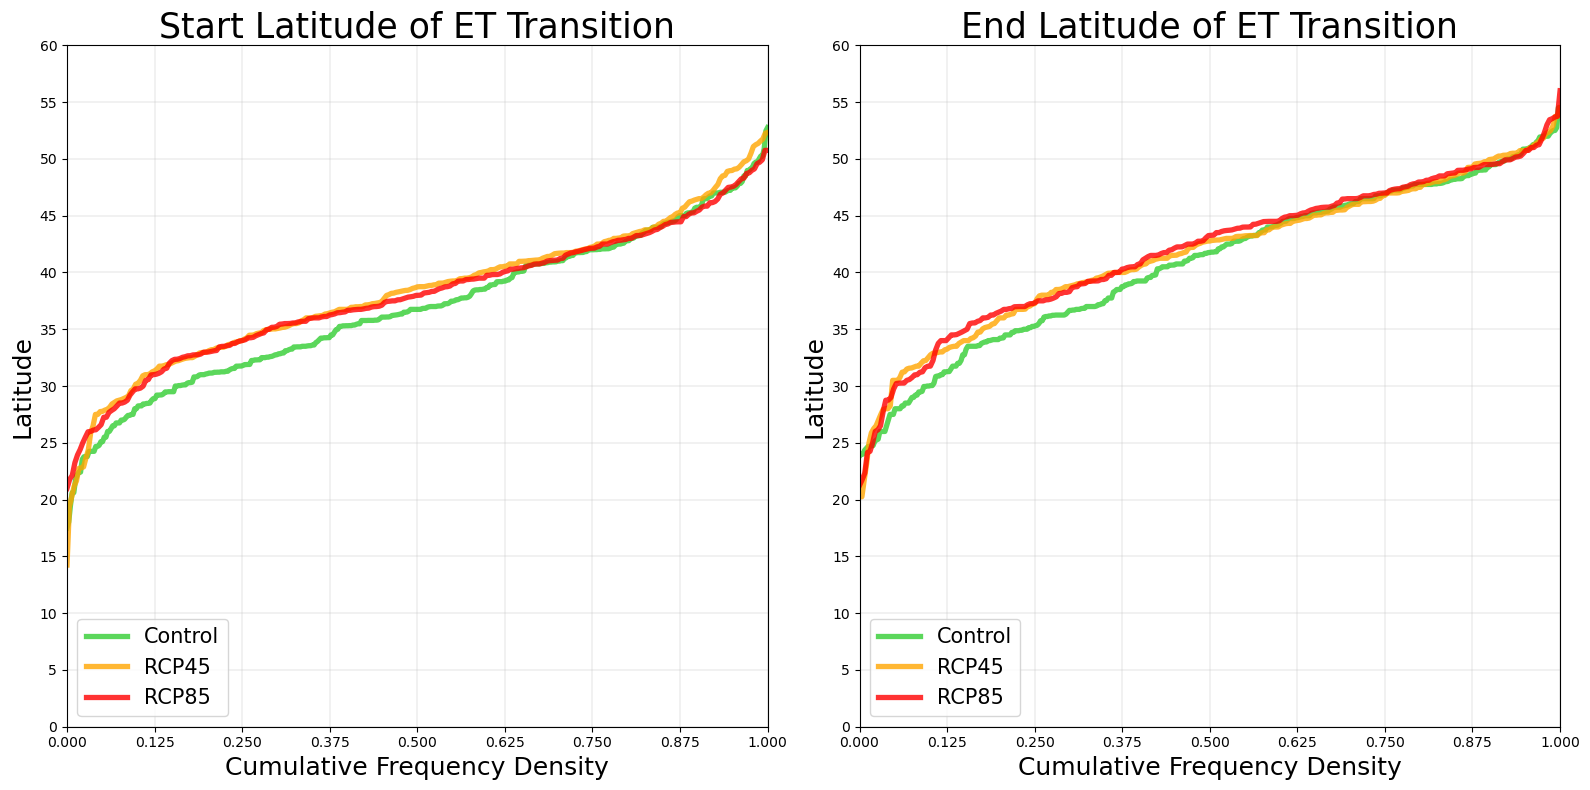

In [23]:
# Start Lat and End Lat
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Lat")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End Lat")
pyplot.tight_layout()
Figname = str('ET_Latitude_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

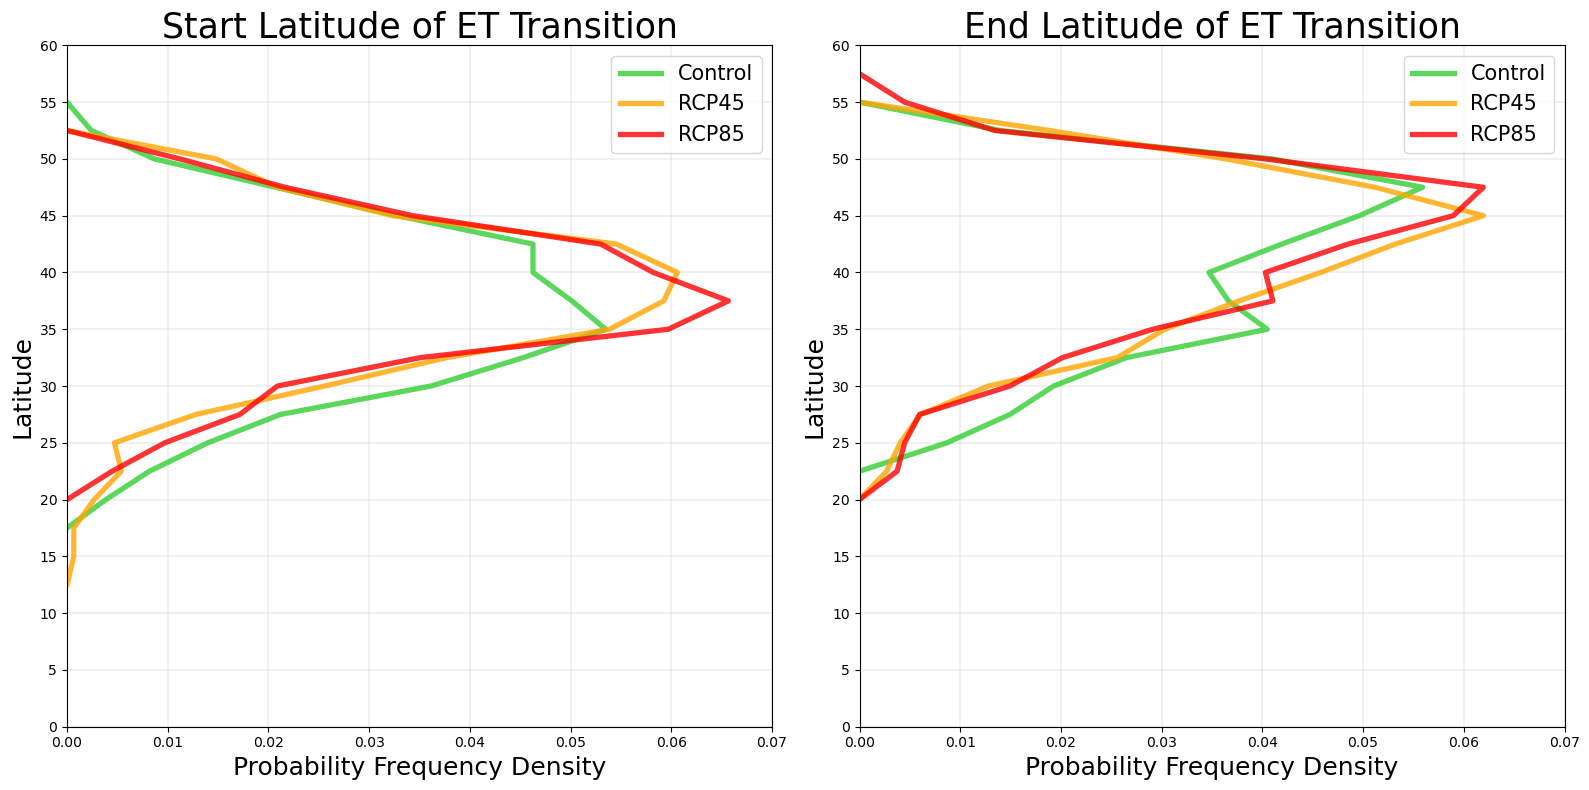

In [24]:
# Start Lat and End Lat
Fig = pyplot.figure(figsize=(16,8))
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Lat")
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End Lat")
pyplot.tight_layout()
Figname = str('ET_Latitude_Prob.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

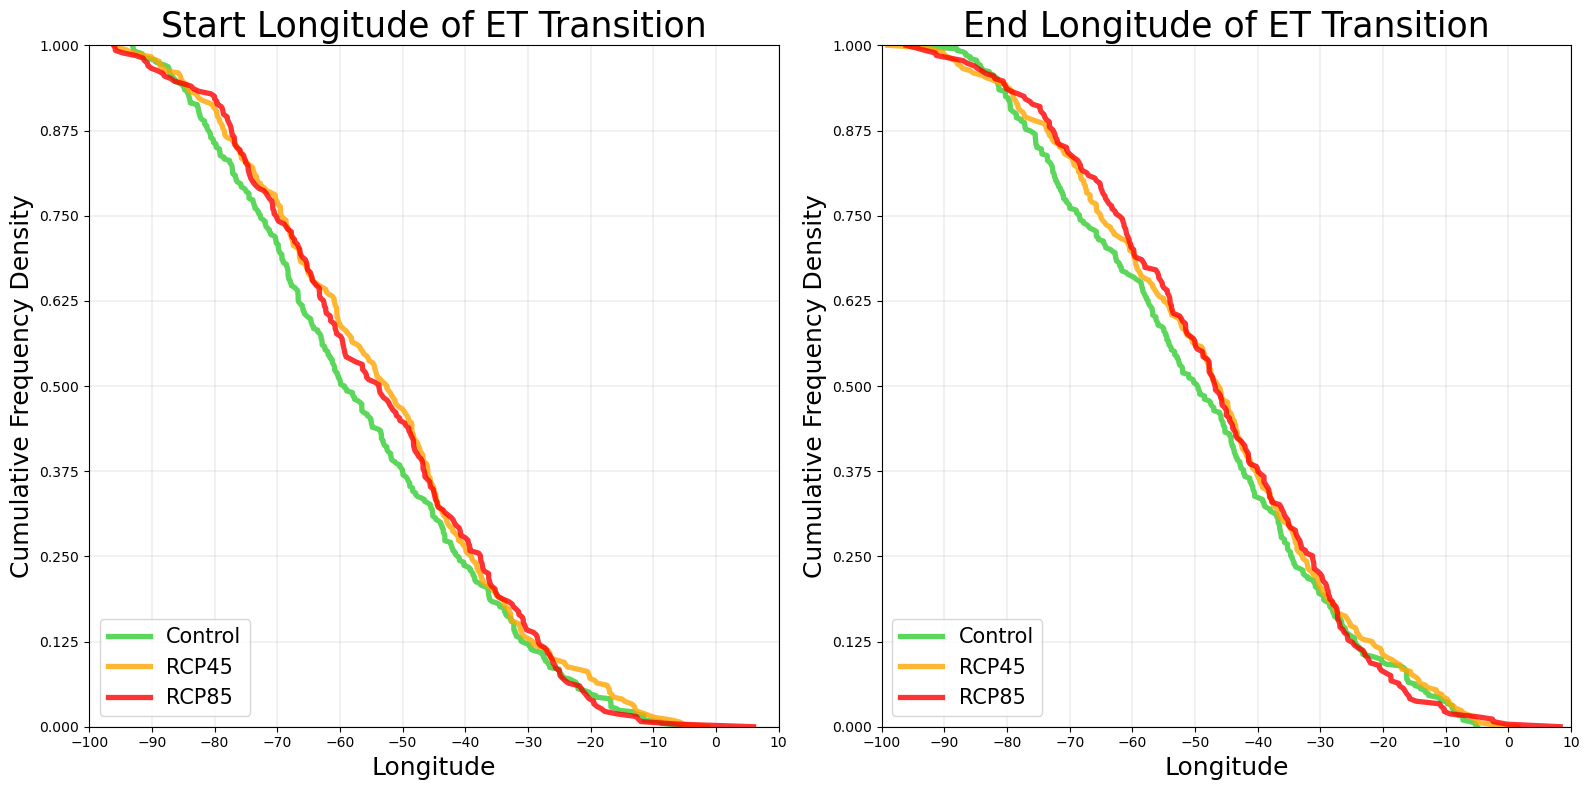

In [25]:
# Start Lon and End Lon
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Lon")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End Lon")
pyplot.tight_layout()
Figname = str('ET_Longitude_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

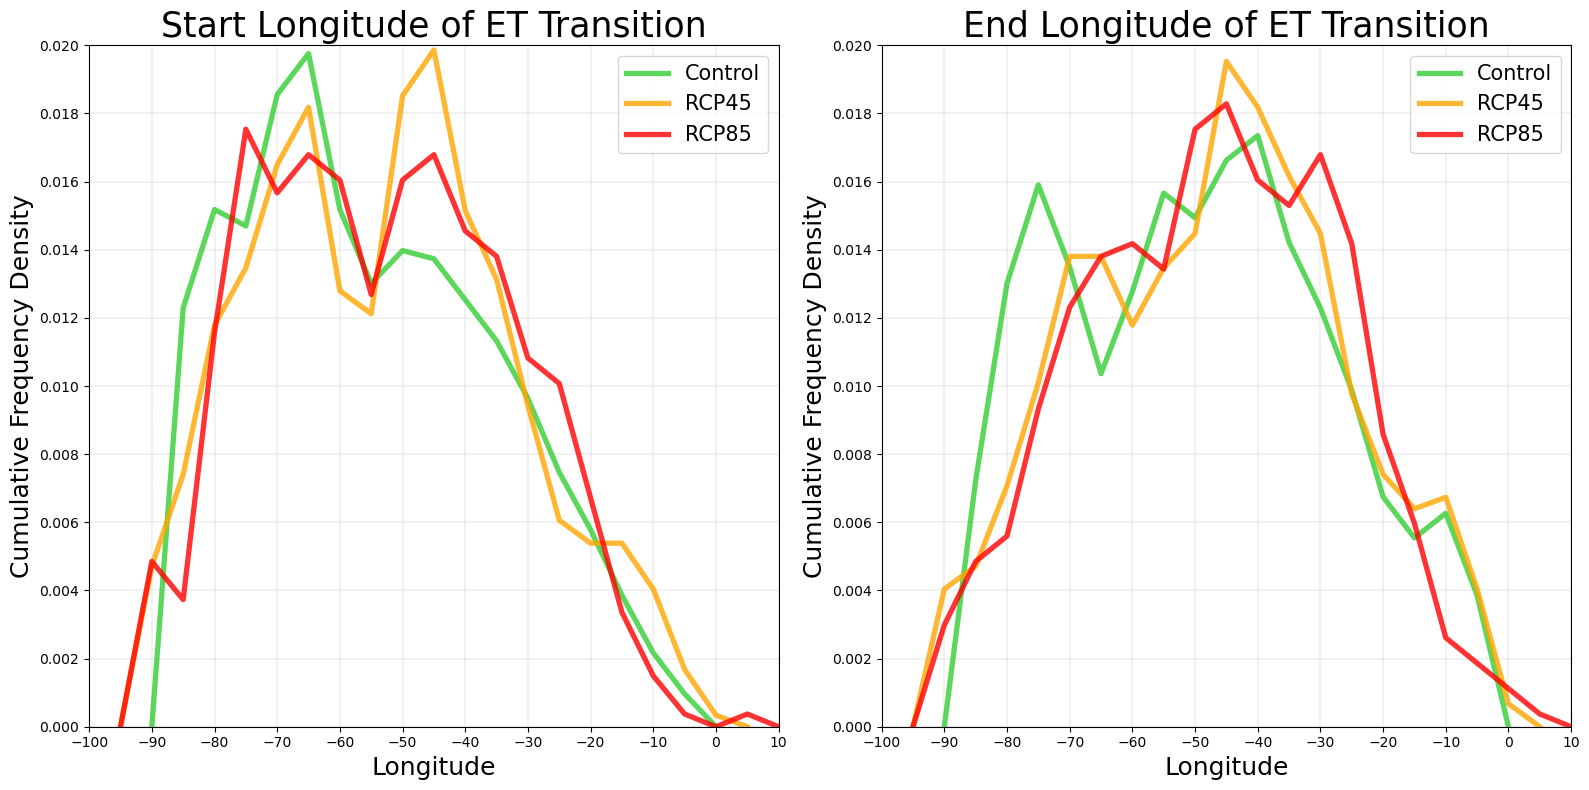

In [26]:
# Start Lon and End Lon
Fig = pyplot.figure(figsize=(16,8))
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Lon")
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End Lon")
pyplot.tight_layout()
Figname = str('ET_Longitude_Prob.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

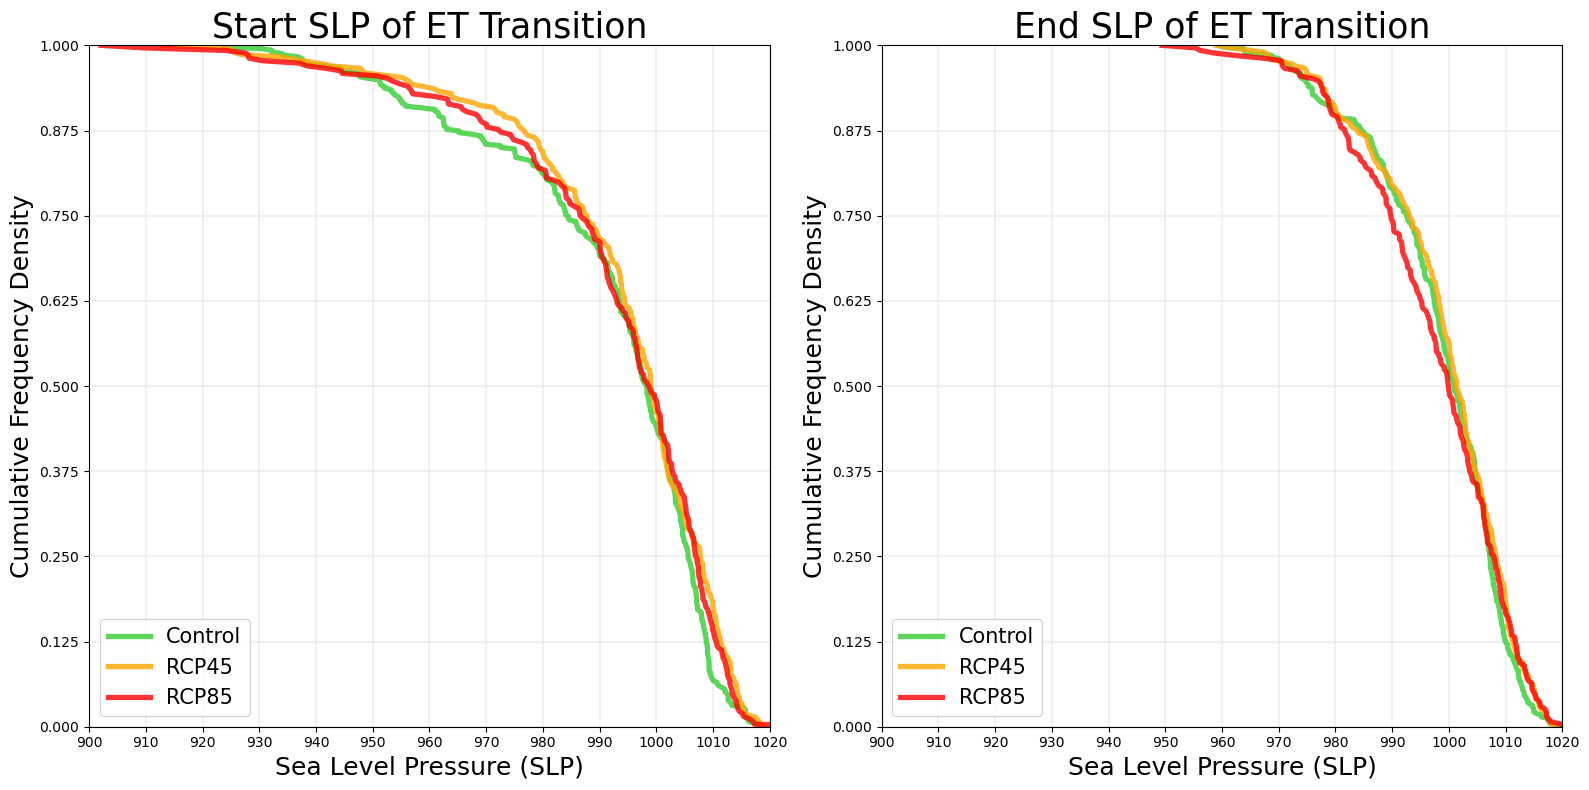

In [27]:
# Start SLP and End SLP
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start SLP")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End SLP")
pyplot.tight_layout()
Figname = str('ET_SLP_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

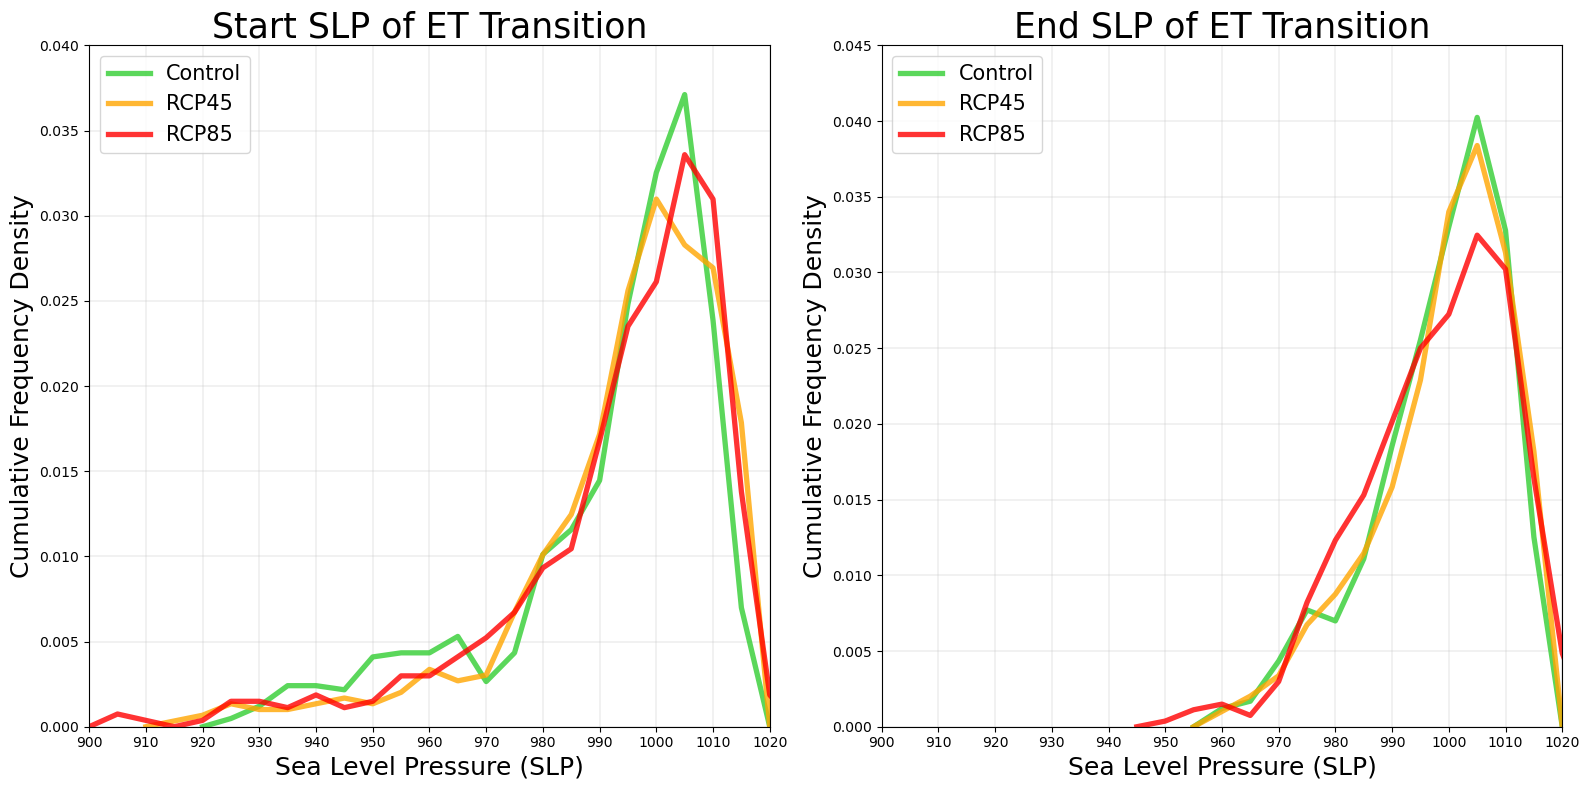

In [28]:
# Start SLP and End SLP
Fig = pyplot.figure(figsize=(16,8))
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start SLP")
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End SLP")
pyplot.tight_layout()
Figname = str('ET_SLP_Prob.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

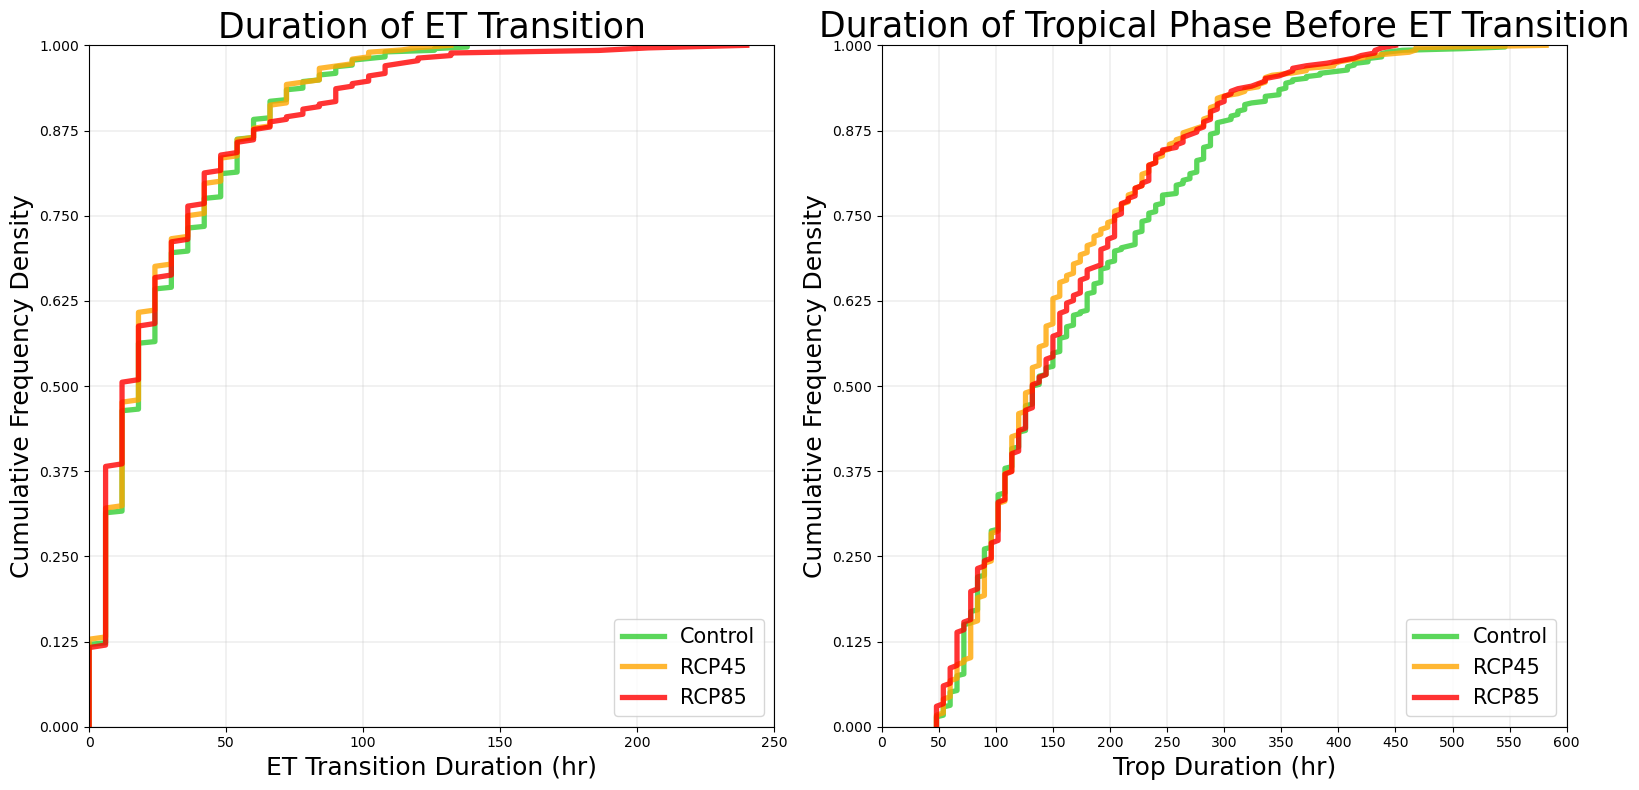

In [29]:
# ET Durations
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Duration (hr)")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Trop Duration (hr)")
pyplot.tight_layout()
Figname = str('ET_Durations_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

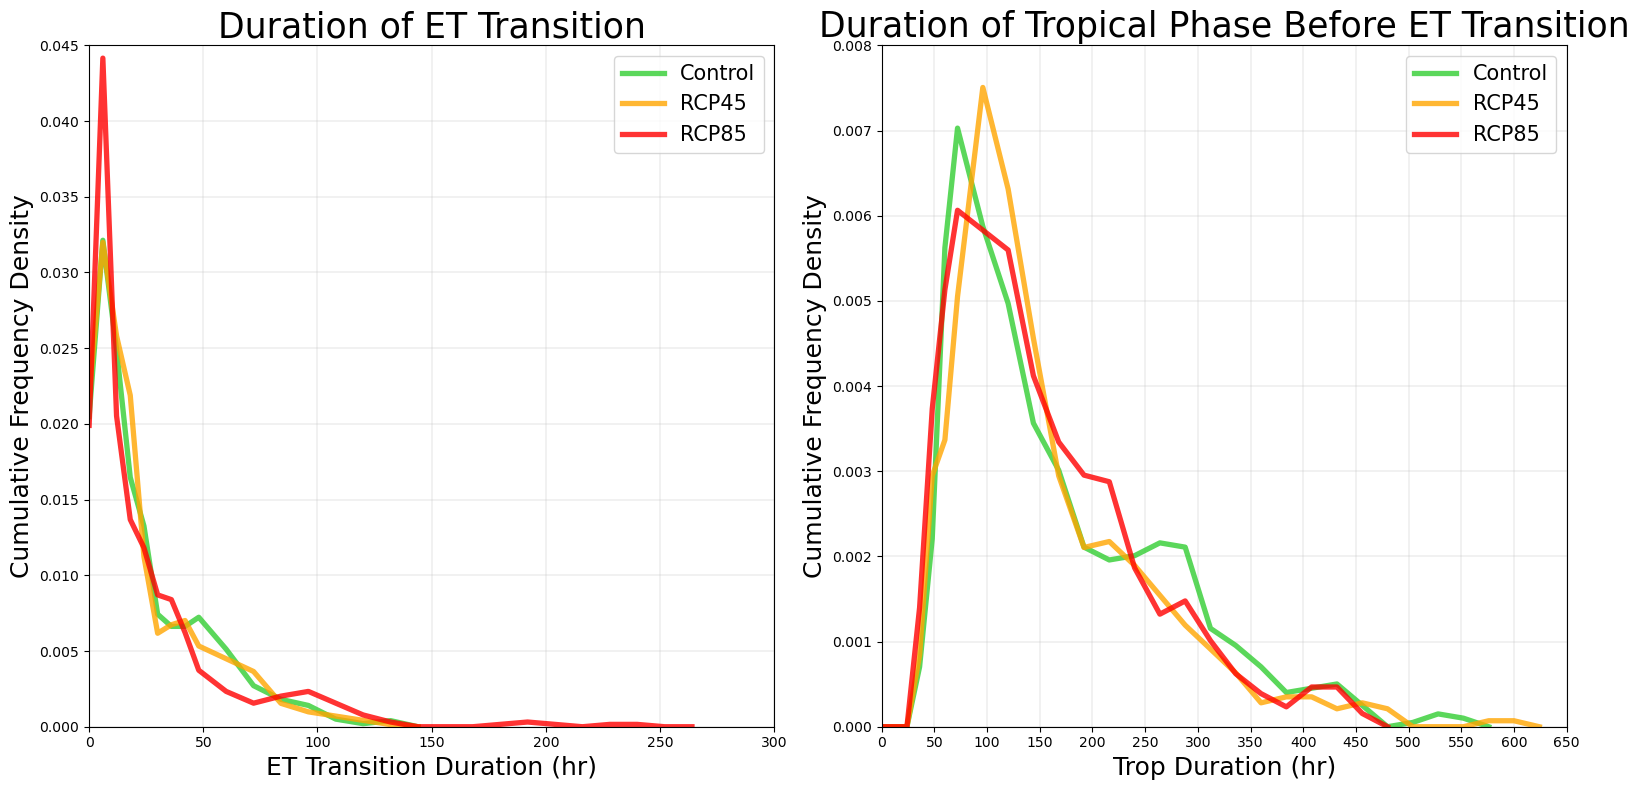

In [30]:
# ET Duration and Tropical Duration
Fig = pyplot.figure(figsize=(16,8))
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Duration (hr)")
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Trop Duration (hr)")
pyplot.tight_layout()
Figname = str('ET_Durations_Prob.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

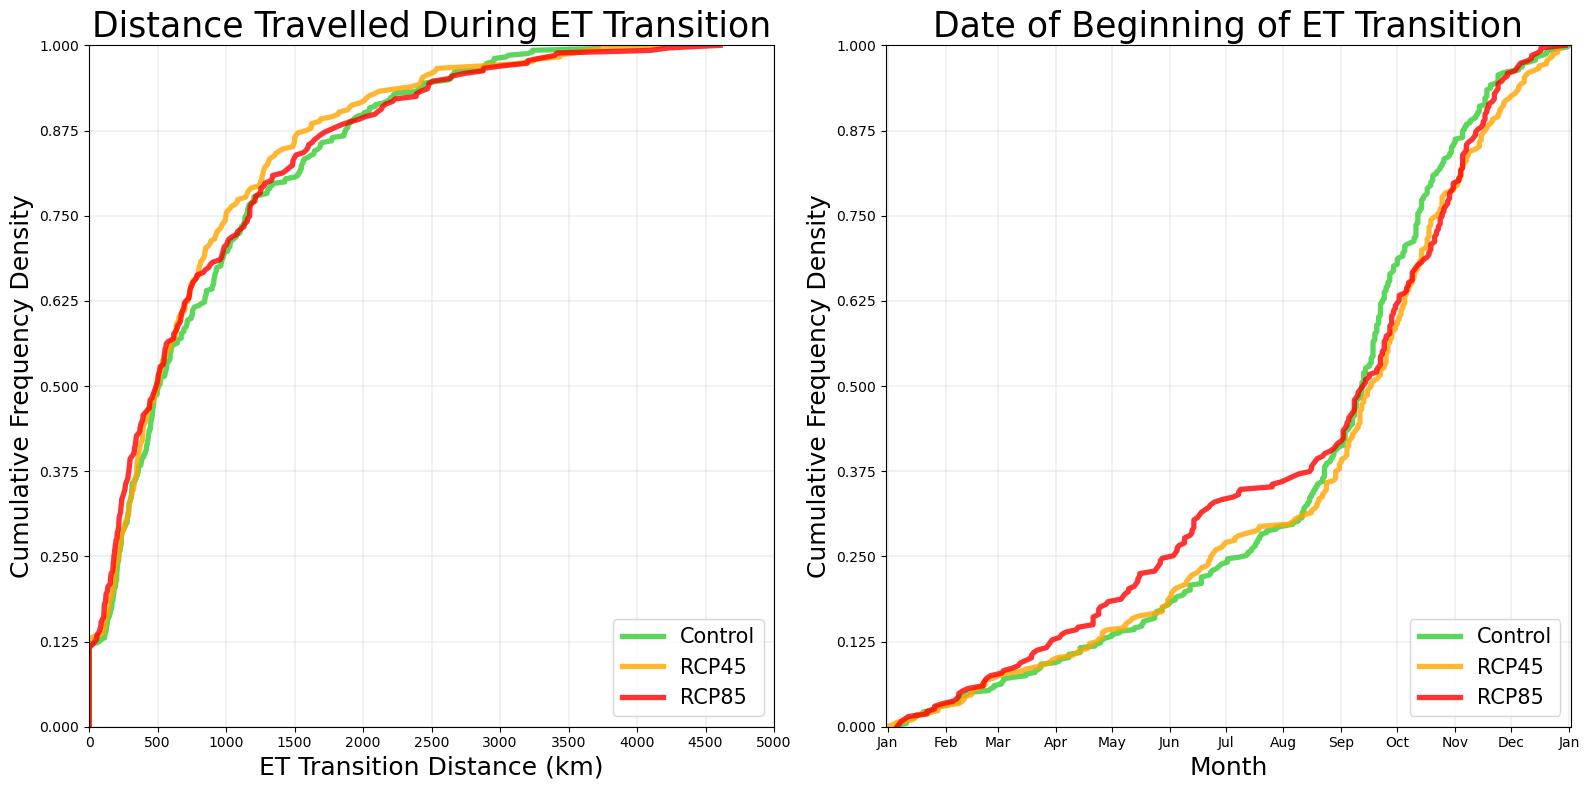

In [31]:
# ET Distance and Start Date
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Dist (km)")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Time")
pyplot.tight_layout()
Figname = str('ET_Distance_Month_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

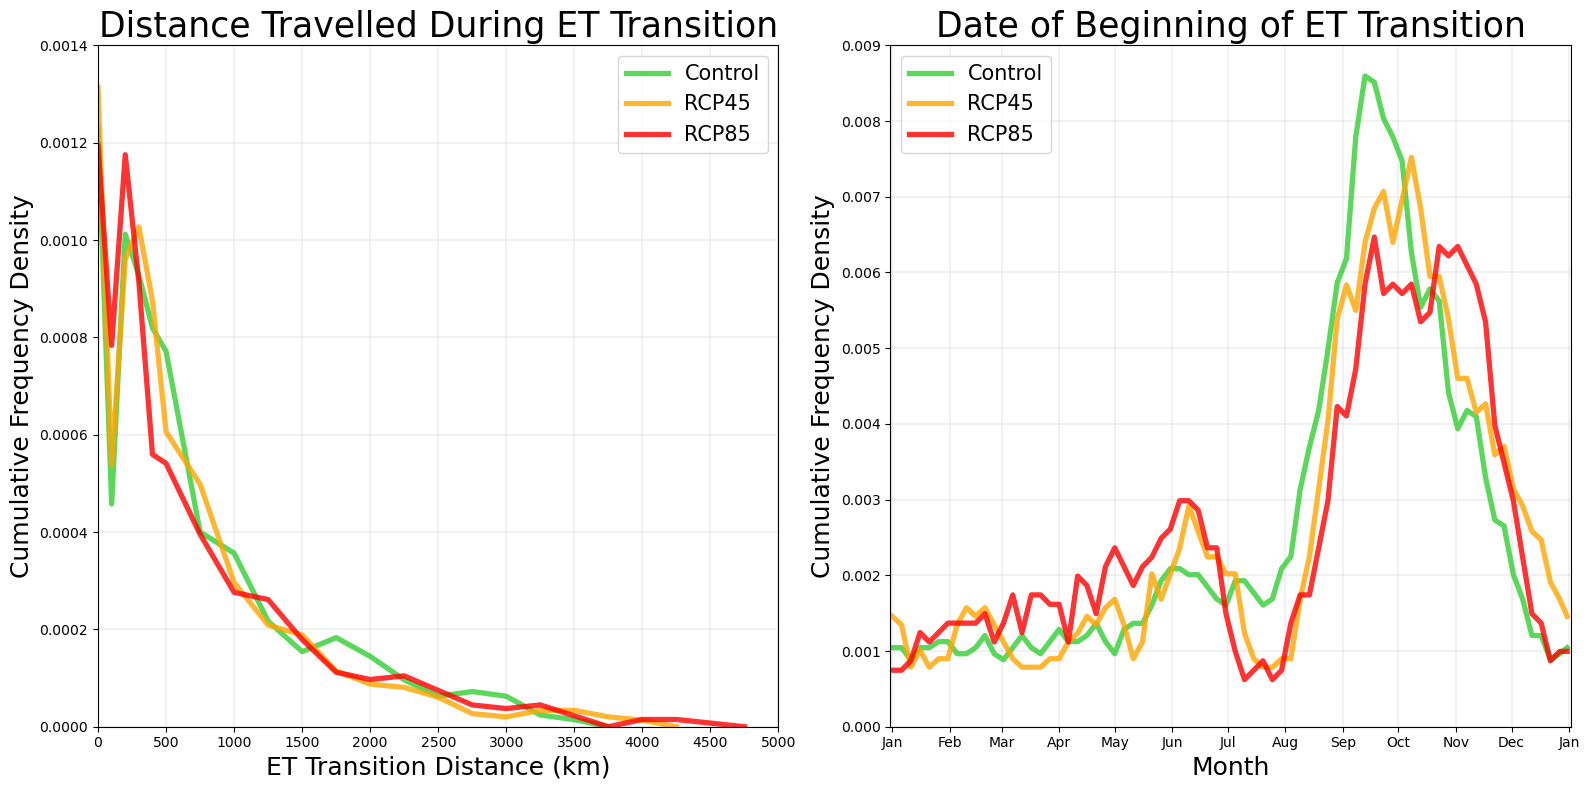

In [32]:
# ET Distance and Date
Fig = pyplot.figure(figsize=(16,8))
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Dist (km)")
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Time")
pyplot.tight_layout()
Figname = str('ET_Distance_Month_Prob.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

In [33]:
# Additional Variables

In [34]:
def Transitioning_SLP(ET_DF, Data_DF):
    Min_SLP_Trans = []
    Min_SLP_Post = []
    End_Start_SLP = []
    Min_Start_SLP = []
    for i in range(len(ET_DF)):
        Start_Time = ET_DF["Start Time"][i]
        End_Time = ET_DF["End Time"][i]
        Code = ET_DF["Code"][i]
        DF_Storm = Find_Storm(Data_DF, Code)
        DF_Storm = DF_Storm.drop("level_0", axis=1)
        DF_Storm_Trans = DF_Storm[(DF_Storm["Time(Z)"] >= Start_Time) & (DF_Storm["Time(Z)"] <= End_Time)]\
        .reset_index()
        DF_Storm_Post = DF_Storm[DF_Storm["Time(Z)"] > End_Time].reset_index()
        if len(DF_Storm_Trans) > 0:
            Start_SLP = DF_Storm_Trans["SLP(hPa)"][0]
            End_SLP = DF_Storm_Trans["SLP(hPa)"][len(DF_Storm_Trans)-1]
            Min_Trans = numpy.min(DF_Storm_Trans["SLP(hPa)"])
            End_Start_Diff = End_SLP - Start_SLP
            Min_Start_Diff = Min_Trans - Start_SLP
            Min_SLP_Trans.append(Min_Trans)
            End_Start_SLP.append(End_Start_Diff)
            Min_Start_SLP.append(Min_Start_Diff)
        else:
            Min_SLP_Trans.append(numpy.nan)
            End_Start_SLP.append(numpy.nan)
            Min_Start_SLP.append(numpy.nan)
        if len(DF_Storm_Post) > 0:
            Min_Post = numpy.min(DF_Storm_Post["SLP(hPa)"])
            Min_SLP_Post.append(Min_Post)
        else:
            Min_SLP_Post.append(numpy.nan)
    ET_DF["Transitioning Min SLP"] = Min_SLP_Trans
    ET_DF["Post-transition Min SLP"] = Min_SLP_Post
    ET_DF["Transition End-Start SLP Diff"] = End_Start_SLP
    ET_DF["Transition Min-Start SLP Diff"] = Min_Start_SLP
    return (ET_DF)

In [35]:
Control_ET_V2 = Transitioning_SLP(Control_ET, Control_Data)
RCP45_ET_V2 = Transitioning_SLP(RCP45_ET, RCP45_Data)
RCP85_ET_V2 = Transitioning_SLP(RCP85_ET, RCP85_Data)

In [36]:
RCP85_ET_V2

,Code,Name,Path Type,Start Time,End Time,Min SLP,Start SLP,End SLP,Start Lon,Start Lat,End Lon,End Lat,ET Dist (km),ET Duration (hr),Trop Duration (hr),Days,Transitioning Min SLP,Post-transition Min SLP,Transition End-Start SLP Diff,Transition Min-Start SLP Diff
0,TC210003,Colin,1,2100-03-13 12:00:00,2100-03-13 18:00:00,976.18,1007.62,1009.57,-41.50,37.00,-41.50,36.00,111.315687,6.0,144.0,71,1007.62,1009.96,1.95,0.00
1,TC210004,Dawn,1,2100-08-23 18:00:00,2100-08-26 06:00:00,924.07,953.47,980.31,-46.85,41.06,-20.61,49.55,2234.489535,60.0,240.0,234,953.47,981.48,26.84,0.00
2,TC210103,Jessica,2,2101-03-03 18:00:00,2101-03-04 00:00:00,943.01,970.11,971.02,-32.30,41.93,-29.14,42.38,265.504016,6.0,66.0,61,970.11,966.29,0.91,0.00
3,TC210105,Lydia,2,2101-09-01 06:00:00,2101-09-01 12:00:00,968.16,1003.30,1001.84,-76.85,39.42,-74.73,41.55,297.331913,6.0,270.0,243,1001.84,995.53,-1.46,-1.46
4,TC210203,Tony,1,2102-09-28 12:00:00,2102-10-01 06:00:00,973.10,996.27,985.49,-72.10,34.29,-54.04,47.37,2086.546198,66.0,360.0,270,973.10,990.47,-10.78,-23.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,TC218806,Laurel,3,2188-10-22 00:00:00,2188-10-22 00:00:00,941.98,1008.04,1008.04,-41.75,42.25,-41.75,42.25,0.000000,0.0,372.0,295,1008.04,1008.86,0.00,0.00
264,TC218901,Micah,3,2189-01-08 12:00:00,2189-01-08 12:00:00,984.84,990.21,990.21,-54.41,45.39,-54.41,45.39,0.000000,0.0,96.0,7,990.21,984.84,0.00,0.00
265,TC218902,Olivia,2,2189-03-19 12:00:00,2189-03-19 18:00:00,990.36,1013.44,1012.53,-30.56,32.01,-30.05,31.74,56.811740,6.0,120.0,77,1012.53,1013.19,-0.91,-0.91
266,TC218905,Troy,1,2189-09-28 12:00:00,2189-09-30 12:00:00,902.08,902.08,970.65,-76.81,29.49,-60.52,46.98,2387.649361,48.0,402.0,270,902.08,NaN,68.57,0.00


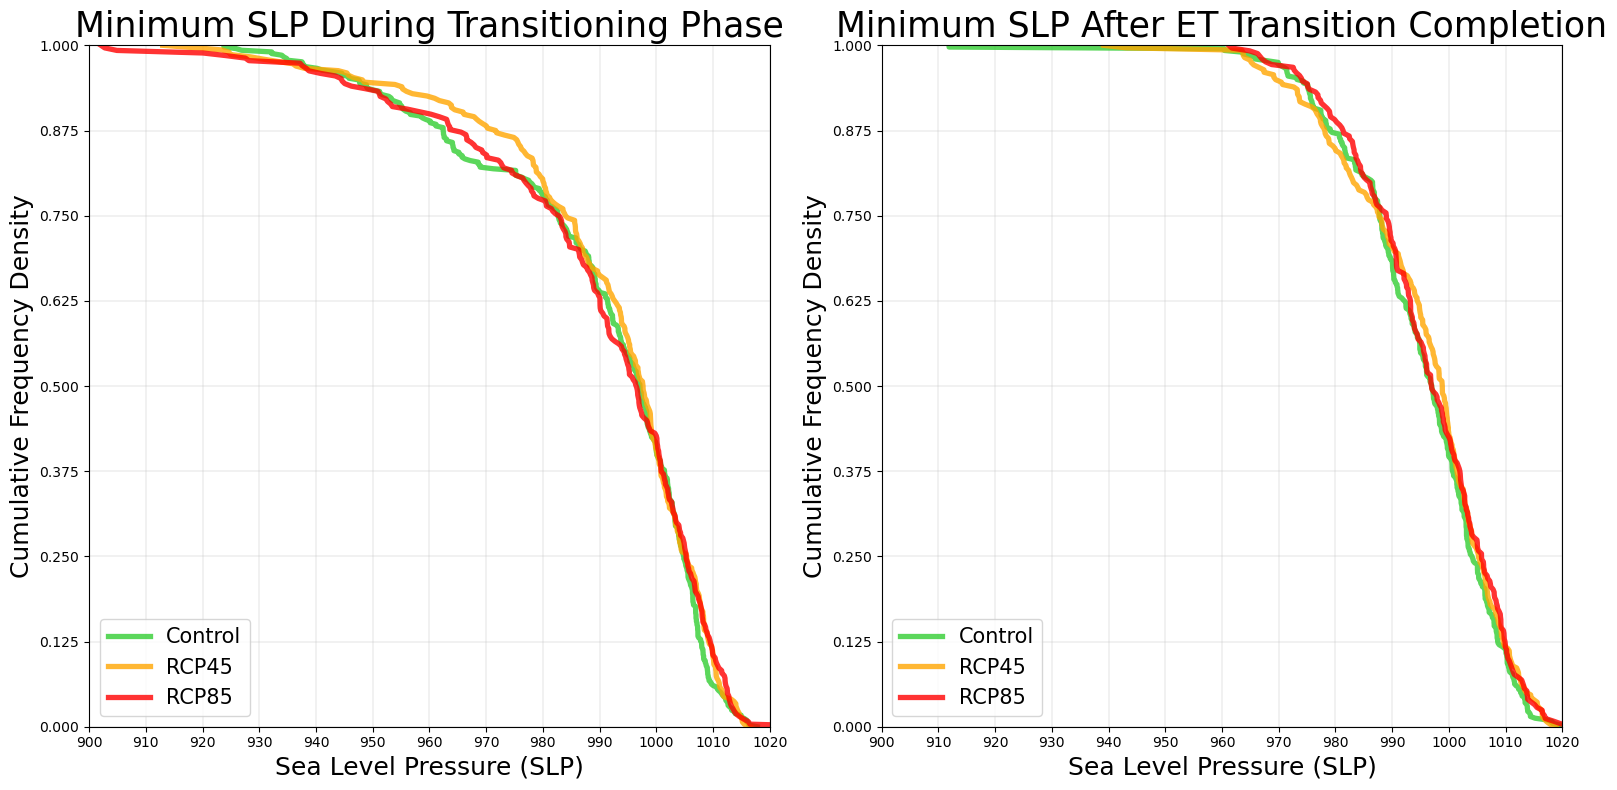

In [37]:
# Start SLP and End SLP
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Transitioning Min SLP")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Post-transition Min SLP")
pyplot.tight_layout()
Figname = str('Trans_SLP_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

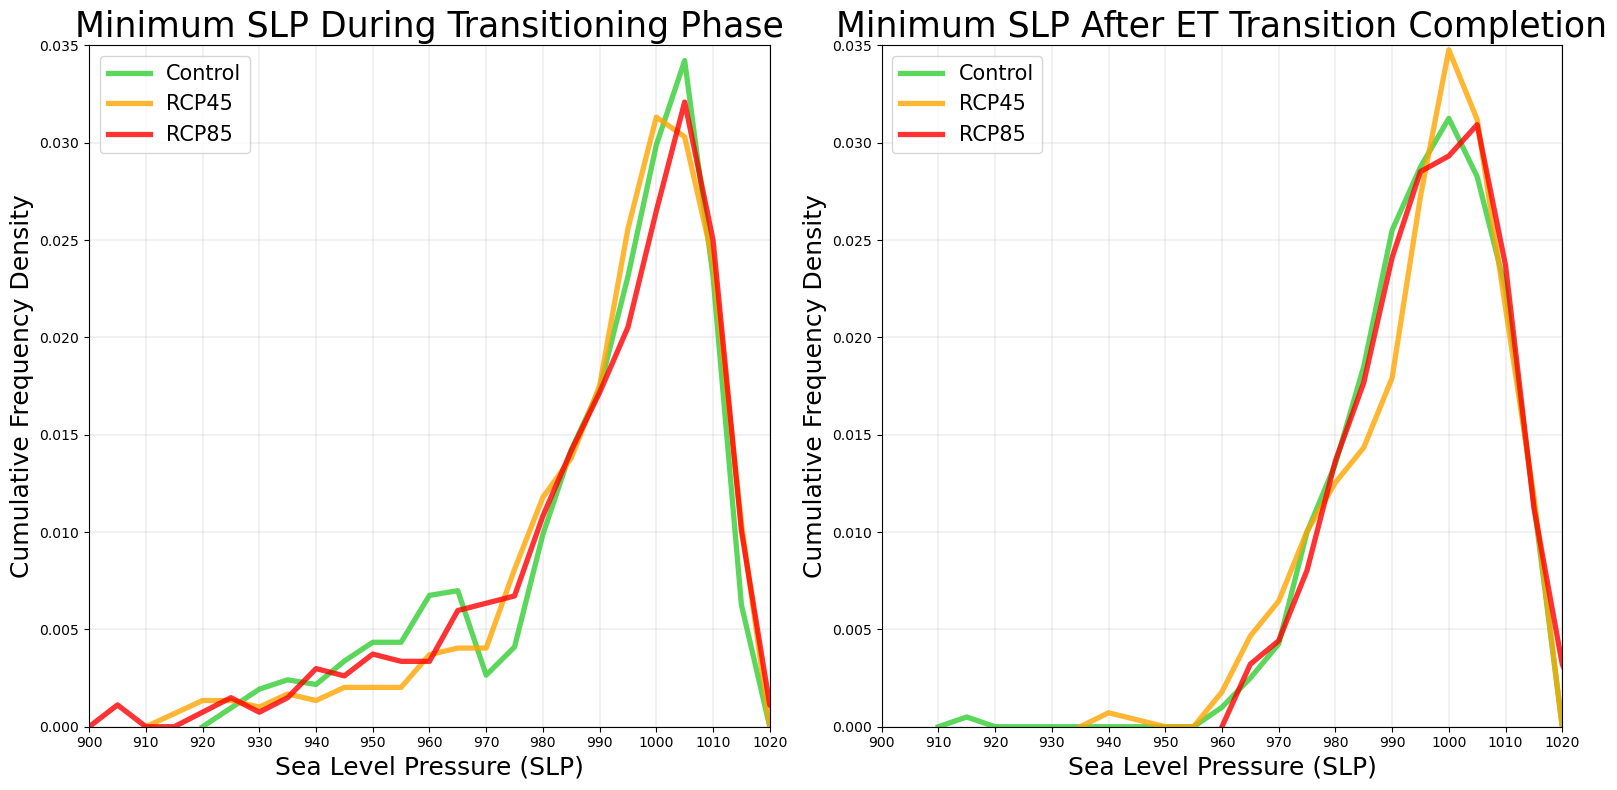

In [38]:
# Start SLP and End SLP
Fig = pyplot.figure(figsize=(16,8))
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Transitioning Min SLP")
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Post-transition Min SLP")
pyplot.tight_layout()
Figname = str('Trans_SLP_Prob.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

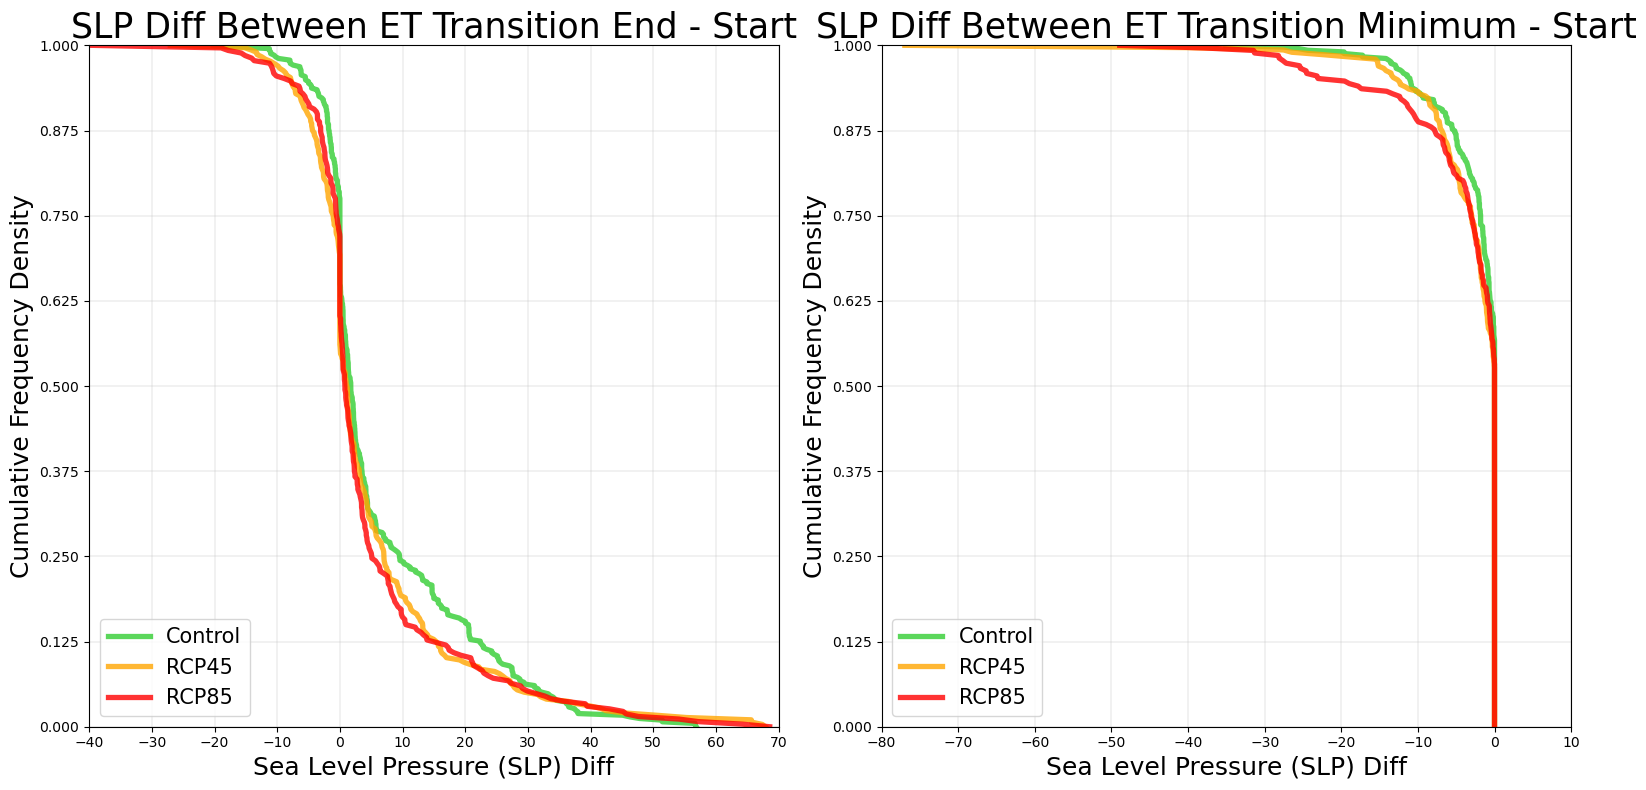

In [39]:
# Start SLP and End SLP
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Transition End-Start SLP Diff")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Transition Min-Start SLP Diff")
pyplot.tight_layout()
Figname = str('SLP_Diffs_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

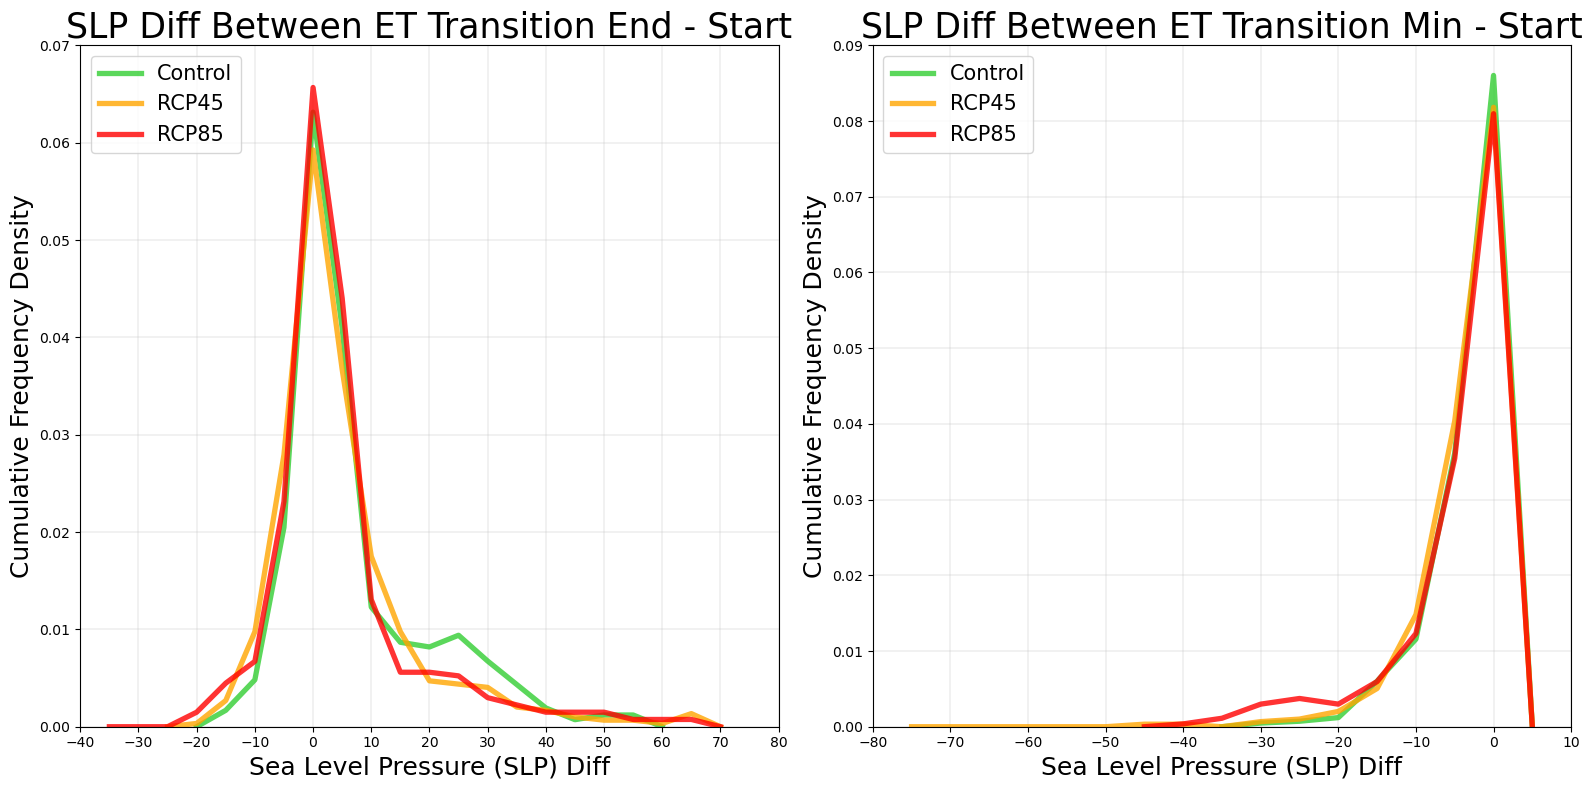

In [40]:
# Start SLP and End SLP
Fig = pyplot.figure(figsize=(16,8))
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Transition End-Start SLP Diff")
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Transition Min-Start SLP Diff")
pyplot.tight_layout()
Figname = str('SLP_Diffs_Prob.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

In [41]:
# Storms That Enter Europe
def Europe(Data_DF, ET_DF):
    Europe_Data = Data_DF[(Data_DF["Lon"] >= -12) & (Data_DF["Lat"] >= 35)].reset_index()
    Europe_ET = ET_DF[ET_DF["Code"].isin(list(Europe_Data["Code"]))].reset_index()
    Europe_Data = Europe_Data.drop("level_0", axis=1)
    Europe_Data = Europe_Data.drop("index", axis=1)
    Europe_ET = Europe_ET.drop("index", axis=1)
    Max_Lon = []
    Min_SLP = []
    for i in range(len(Europe_ET)):
        Code = Europe_ET["Code"][i]
        DF_Storm = Find_Storm(Europe_Data, Code)
        Max_Lon.append(numpy.max(DF_Storm["Lon"]))
        Min_SLP.append(numpy.min(DF_Storm["SLP(hPa)"]))
    Europe_ET["Max Lon"] = Max_Lon
    Europe_ET["Min SLP in Europe"] = Min_SLP
    return (Europe_Data, Europe_ET)

In [42]:
Control_Data_Europe, Control_ET_Europe = Europe(Control_Data, Control_ET)

In [43]:
RCP45_Data_Europe, RCP45_ET_Europe = Europe(RCP45_Data, RCP45_ET)

In [44]:
RCP85_Data_Europe, RCP85_ET_Europe = Europe(RCP85_Data, RCP85_ET)

In [45]:
# Total Number of Storms
def Total_Num_Storms(ET_DF):
    Len = len(ET_DF)
    return (Len)
ET_Totals = numpy.zeros(3)
ET_Totals[0] = Total_Num_Storms(Control_ET)
ET_Totals[1] = Total_Num_Storms(RCP45_ET)
ET_Totals[2] = Total_Num_Storms(RCP85_ET)
ET_Totals

array([415., 297., 268.])

In [46]:
# Cumulative Frequency of Specific Group
def Cum_Freq(Array, Direction, Total_Num):
    Array = Array[Array > -728]
#    print (len(Array))
    if Direction == "Up":
        Sorted = numpy.sort(Array)
    else:
        Sorted = numpy.sort(Array)[::-1]
    Len = len(Sorted)
    Overall_Freq = Len / Total_Num
    Density = numpy.arange(0,Overall_Freq,1/(Total_Num-1))
#    print (len(Density))
    return (Sorted, Density)

In [47]:
numpy.min(Control_ET_Europe["Min SLP in Europe"])

967.91

In [48]:
# Formatting Based on Variable
def Cum_Freq_Formatting(Vals_1, Vals_2, Vals_3, Dens_1, Dens_2, Dens_3, Var, Months):
# x Ticks and Lims
    if Var == "Start SLP" or Var == "End SLP":
        Min = 950
        Max = 1020
        Width = 10
    elif Var == "Max Lon" or Var == "End Lon":
        Min = -15
        Max = 15
        Width = 5
    elif Var == "Min SLP in Europe":
        Min = 960
        Max = 1020
        Width = 10
#    elif Var == "Transition End-Start SLP Diff" or Var == "Transition Min-Start SLP Diff":
#        Width = 10
#        Min_Val = numpy.min([numpy.min(Vals_1), numpy.min(Vals_2), numpy.min(Vals_3)])
#        Max_Val = numpy.max([numpy.max(Vals_1), numpy.max(Vals_2), numpy.max(Vals_3)])
#        Min = (int(Min_Val / Width) - 1) * Width
#        Max = (int(Max_Val / Width) + 1) * Width
    x_Ticks = Create_Bins(Min, Max, Width)
#
# y Ticks and Lims
    Max_Dens = numpy.max([numpy.max(Dens_1), numpy.max(Dens_2), numpy.max(Dens_3)])
    y_Width = 0.02
    y_Max = (int(Max_Dens / y_Width) + 1) * y_Width
    y_Ticks = Create_Bins(0, y_Max, y_Width)
    pyplot.xticks(x_Ticks)
    pyplot.xlim(Min, Max)
    pyplot.yticks(y_Ticks)
    pyplot.ylim(0,y_Max)
#
# Labels and Title
    pyplot.ylabel("Cumulative Frequency", fontsize=18)
    if Var == "Start SLP" or Var == "End SLP":
        pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
        Title = Var + " of ET Transition in " + Months
    elif Var == "Max Lon":
        pyplot.xlabel("Longitude", fontsize=18)
        Title = "Max Longitude of Storms Reaching Europe"
    elif Var == "Min SLP in Europe":
        pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
        Title = "Min SLP of Storms within Europe"
    pyplot.title(Title, fontsize=25)
#
# Legend
    pyplot.legend(loc=1, fontsize=15)

In [65]:
# Create Function to Plot ET Cumulative Distributions
def ET_Cum_Freq_Plot(Fig, ET_DF_1, ET_DF_2, ET_DF_3, Var, Months):
    if Var == "Max Lon" or Var == "Start SLP":
        Axis = Fig.add_subplot(1,2,1)
    elif Var == "Min SLP in Europe" or Var == "End SLP":
        Axis = Fig.add_subplot(1,2,2)
#
# Apply Cumulative Distribution Function
#    if Var == "Start Lat" or Var == "End Lat" or Var == "ET Duration (hr)" or Var == "ET Dist (km)" or \
#    Var == "Trop Duration (hr)":
#        Sorted_1, Density_1 = Cum_Dist(ET_DF_1[Var], "Up")
#        Sorted_2, Density_2 = Cum_Dist(ET_DF_2[Var], "Up")
#        Sorted_3, Density_3 = Cum_Dist(ET_DF_3[Var], "Up")
    if Var == "Start SLP" or Var == "End SLP" or Var == "Max Lon" or Var == "Min SLP in Europe":
        Sorted_1, Density_1 = Cum_Freq(ET_DF_1[Var], "Down", ET_Totals[0])
        Sorted_2, Density_2 = Cum_Freq(ET_DF_2[Var], "Down", ET_Totals[1])
        Sorted_3, Density_3 = Cum_Freq(ET_DF_3[Var], "Down", ET_Totals[2])
#
# Plotting
#    if Var == "Start Lat" or Var == "End Lat":
#        Axis.plot(Density_1, Sorted_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
#        Axis.plot(Density_2, Sorted_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
#        Axis.plot(Density_3, Sorted_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    if Var != "Max Lon":
        Axis.plot(Sorted_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Sorted_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Sorted_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Sorted_1, Density_1, color='limegreen', linewidth=3.8, alpha=0.8)
        Axis.plot(Sorted_2, Density_2, color='orange', linewidth=3.8, alpha=0.8)
        Axis.plot(Sorted_3, Density_3, color='red', linewidth=3.8, alpha=0.8)
        Axis.plot([-9,-9], [0,1], color='cyan', linewidth=2.8, label='Lisbon', linestyle='--', alpha=0.7)
        Axis.plot([-6,-6], [0,1], color='deepskyblue', linewidth=2.8, label='Dublin', linestyle='--', alpha=0.7)
        Axis.plot([0,0], [0,1], color='dodgerblue', linewidth=2.8, label='London', linestyle='--', alpha=0.7)
        Axis.plot([5,5], [0,1], color='navy', linewidth=2.8, label='Amsterdam', linestyle='--', alpha=0.7)
    Axis.plot([-728,7428], [numpy.max(Density_1),numpy.max(Density_1)], \
    color='limegreen', linewidth=1.8, linestyle='--', alpha=0.5)
    Axis.plot([-728,7428], [numpy.max(Density_2),numpy.max(Density_2)], \
    color='orange', linewidth=1.8, linestyle='--', alpha=0.5)
    Axis.plot([-728,7428], [numpy.max(Density_3),numpy.max(Density_3)], \
    color='red', linewidth=1.8, linestyle='--', alpha=0.5)
#
# Formatting Based on Variable
    Cum_Freq_Formatting(Sorted_1, Sorted_2, Sorted_3, Density_1, Density_2, Density_3, Var, Months)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

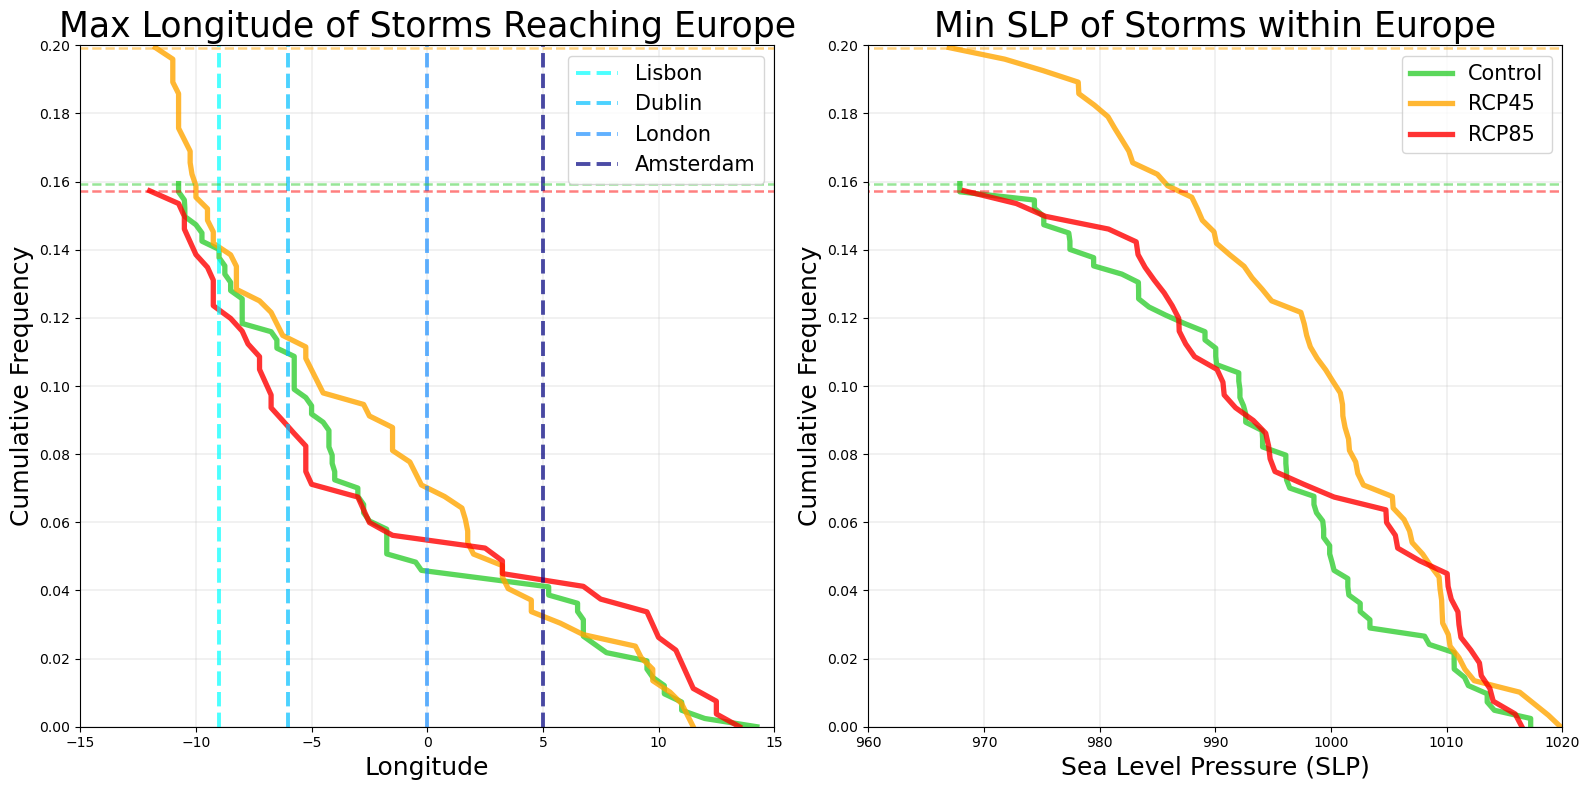

In [52]:
# Start SLP and End SLP
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Freq_Plot(Fig, Control_ET_Europe, RCP45_ET_Europe, RCP85_ET_Europe, "Max Lon", "")
ET_Cum_Freq_Plot(Fig, Control_ET_Europe, RCP45_ET_Europe, RCP85_ET_Europe, "Min SLP in Europe", "")
pyplot.tight_layout()
Figname = str('Europe_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

In [53]:
def Months(Data_DF):
    Month = []
    for j in range(len(Data_DF)):
        Month.append(Data_DF["Time(Z)"][j].month)
    Data_DF["Month"] = Month
    return (Data_DF)

In [54]:
Control_Data_Months = Months(Control_Data)
RCP45_Data_Months = Months(RCP45_Data)
RCP85_Data_Months = Months(RCP85_Data)

In [55]:
# Storms in Different Seasons
def Jan_Jun(Data_DF, ET_DF):
    Months_Data = Data_DF[(Data_DF["Month"] >= 1) & (Data_DF["Month"] <= 6)].reset_index()
    Months_ET =  ET_DF[ET_DF["Code"].isin(list(Months_Data["Code"]))].reset_index()
    Months_Data = Months_Data.drop("level_0", axis=1)
    Months_Data = Months_Data.drop("index", axis=1)
    Months_ET = Months_ET.drop("index", axis=1)
    return (Months_Data, Months_ET)

In [56]:
# Storms in Different Seasons
def Jan_Mar(Data_DF, ET_DF):
    Months_Data = Data_DF[(Data_DF["Month"] >= 1) & (Data_DF["Month"] <= 3)].reset_index()
    Months_ET =  ET_DF[ET_DF["Code"].isin(list(Months_Data["Code"]))].reset_index()
    Months_Data = Months_Data.drop("level_0", axis=1)
    Months_Data = Months_Data.drop("index", axis=1)
    Months_ET = Months_ET.drop("index", axis=1)
    return (Months_Data, Months_ET)

In [57]:
Control_Data_Jan_Jun, Control_ET_Jan_Jun = Jan_Jun(Control_Data_Months, Control_ET)

In [58]:
RCP45_Data_Jan_Jun, RCP45_ET_Jan_Jun = Jan_Jun(RCP45_Data_Months, RCP45_ET)

In [59]:
RCP85_Data_Jan_Jun, RCP85_ET_Jan_Jun = Jan_Jun(RCP85_Data_Months, RCP45_ET)

In [60]:
Control_Data_Jan_Mar, Control_ET_Jan_Mar = Jan_Mar(Control_Data_Months, Control_ET)

In [61]:
RCP45_Data_Jan_Mar, RCP45_ET_Jan_Mar = Jan_Mar(RCP45_Data_Months, RCP45_ET)

In [62]:
RCP85_Data_Jan_Mar, RCP85_ET_Jan_Mar = Jan_Mar(RCP85_Data_Months, RCP85_ET)

In [63]:
# Start SLP and End SLP
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Freq_Plot(Fig, Control_ET_Jan_Jun, RCP45_ET_Jan_Jun, RCP85_ET_Jan_Jun, "Start SLP", "Jan-Jun")
ET_Cum_Freq_Plot(Fig, Control_ET_Jan_Jun, RCP45_ET_Jan_Jun, RCP85_ET_Jan_Jun, "End SLP", "Jan-Jun")
pyplot.tight_layout()
Figname = str('Jan_Jun_SLP_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

TypeError: ET_Cum_Freq_Plot() takes 5 positional arguments but 6 were given

<Figure size 1600x800 with 0 Axes>

In [64]:
# Start SLP and End SLP
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Freq_Plot(Fig, Control_ET_Jan_Mar, RCP45_ET_Jan_Mar, RCP85_ET_Jan_Mar, "Start SLP", "Jan-Mar")
ET_Cum_Freq_Plot(Fig, Control_ET_Jan_Mar, RCP45_ET_Jan_Mar, RCP85_ET_Jan_Mar, "End SLP", "Jan-Mar")
pyplot.tight_layout()
Figname = str('Jan_Mar_SLP_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

TypeError: ET_Cum_Freq_Plot() takes 5 positional arguments but 6 were given

<Figure size 1600x800 with 0 Axes>